In [12]:
import math 
import pandas_datareader as web 
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import sys
import plotly.graph_objects as go
from sklearn.model_selection import GridSearchCV

In [13]:
# getting stock quote 
df = web.DataReader('AAPL', data_source='yahoo', start = '2013-01-01', end = '2020-06-26')
df = df.reset_index()

In [14]:
# visualizing AAPL close price history 
trace = go.Scatter(x = df['Date'], y = df['Close'], marker = {'color':"#3f8fcc"})
layout = go.Layout(title = {'text':'AAPL 10Y <b>Close price</b>','x':0.5,'y':0.88,'font':{'color':'#404040'}},plot_bgcolor="white")
layout.xaxis.gridcolor = "#e3e3e3"
layout.yaxis.gridcolor = "#e3e3e3"
layout.xaxis.title.text = "03 June 2009 - 03 June 2019"
layout.yaxis.title.text = "AAPL close price"
fig = go.Figure(data = [trace], layout = layout)
fig.show()

In [15]:
# creating new dataframe 
data = df.filter(['Close'])

# Convert dataframe into a numpy array 
dataset = data.values

# training length 
x_train_len = math.ceil(0.8 * len(dataset))

In [16]:
# Scale the data - pre-processing 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [17]:
# training data set
# scaled training dataset 
train_data = scaled_data[0:x_train_len, :]

# split data
x_train = [] 
y_train = []

for i in range(60, len(train_data)):
  # stores an array of the past 60 day history as we move on in the timeseries
  x_train.append(train_data[i-60:i, 0])
  # would always contain the 61st day data in the time series as we move through
  y_train.append(train_data[i, 0])


In [18]:
# convert x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

In [19]:
# reshape the data
# reshape into a 3-D (#samples, #timesteps, #features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [20]:
# Build the LSTM model 
def create_model():
  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dense(25, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=["accuracy"])
  return model 

In [21]:
# Compile the model 
model = create_model()
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
#Train the model
history = model.fit(x_train, y_train, batch_size=2, epochs = 25,validation_split=0.2)

Train on 1158 samples, validate on 290 samples
Epoch 1/25
1158/1158 [==============================] - 211s 182ms/step - loss: 5.1576e-04 - val_loss: 0.0015
Epoch 2/25
1158/1158 [==============================] - 214s 185ms/step - loss: 1.7339e-04 - val_loss: 5.3019e-04
Epoch 3/25
1158/1158 [==============================] - 223s 192ms/step - loss: 1.5316e-04 - val_loss: 3.2722e-04
Epoch 4/25
1158/1158 [==============================] - 212s 183ms/step - loss: 1.1671e-04 - val_loss: 2.4346e-04
Epoch 5/25
1158/1158 [==============================] - 213s 184ms/step - loss: 1.0772e-04 - val_loss: 6.9549e-04
Epoch 6/25
1158/1158 [==============================] - 213s 184ms/step - loss: 8.7436e-05 - val_loss: 1.9158e-04
Epoch 7/25
1158/1158 [==============================] - 219s 189ms/step - loss: 7.7319e-05 - val_loss: 1.9714e-04
Epoch 8/25
1158/1158 [==============================] - 214s 184ms/step - loss: 8.0560e-05 - val_loss: 3.6496e-04
Epoch 9/25
1158/1158 [=======================

In [22]:

# Hyperparameter tuning 
# params = [{
#     'epochs': [15,20],
#     'batch_size': [5,10]
# }]
# model = KerasClassifier(build_fn=create_model, verbose=0)
# grid_search = GridSearchCV(model, params, scoring = None , n_jobs=-1, verbose = 1, cv = 3)
# %time grid_search.fit(x_train, y_train)
model = keras.models.load_model('my_model')

OSError: ignored

In [23]:

# Visualize the training process
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('epoch')
plt.ylabel('error in prediction')
plt.title('Training and validation error')
plt.legend(loc = 'upper right')
plt.show()

NameError: ignored

<Figure size 720x576 with 0 Axes>

In [17]:
# create testing data
# array containing elts. from (1448 - 60) ...1885
test_data = scaled_data[x_train_len - 60: , :]

x_test = []
y_test = dataset[x_train_len: , :]
for i in range(60, len(test_data)):
  # contains 60 day moving historical recordings
  x_test.append(test_data[i-60:i, 0])



In [18]:
# reshape to fit into LSTM model 
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [19]:
# obtain predictions
predictions = model.predict(x_test)
# de-scaling the values
predictions = scaler.inverse_transform(predictions)

In [20]:
# Quantifying testing RMSE  
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

3.8864858612141497

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



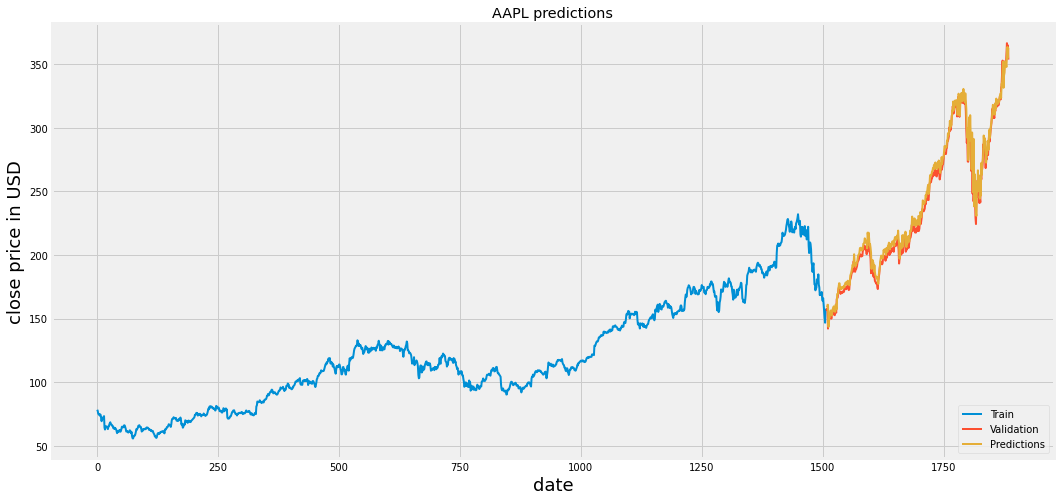

In [21]:
# visualizing data
train = data[:x_train_len]
valid = data[x_train_len:]
valid['Predictions'] = predictions
plt.figure(figsize = (16,8))
plt.title('AAPL predictions')
plt.xlabel('date', fontsize = 18)
plt.ylabel('close price in USD', fontsize = 18)
plt.plot(train['Close'], linewidth = 2)
plt.plot(valid[['Close','Predictions']], linewidth = 2)
plt.legend(['Train','Validation','Predictions'], loc = 'lower right')
plt.show()

In [22]:
# next day prediction
valid

,Close,Predictions
1508,156.229996,158.832733
1509,157.740005,159.170181
1510,157.919998,160.895050
1511,142.190002,160.933228
1512,148.259995,143.552490
...,...,...
1880,358.869995,347.849396
1881,366.529999,358.469360
1882,360.059998,363.546143
1883,364.839996,354.935333


In [23]:
# predicting the price of 2020-06-27
lastSixty = df.filter(['Close'])[-60:].values
# scaling the data
lastSixty = scaler.transform(lastSixty)
# test data
sixty_test = np.array([lastSixty])
# reshape data
sixty_test = np.reshape(sixty_test, (sixty_test.shape[0], sixty_test.shape[1], 1))
prediction = scaler.inverse_transform(model.predict(sixty_test))
actual_value = web.DataReader('AAPL', data_source='yahoo', start = '2020-06-27', end = '2020-06-29')
actual_value

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-06-29,362.170013,351.279999,353.25,361.779999,32661500,361.779999


In [24]:
prediction 

array([[348.58282]], dtype=float32)